In [26]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

# Variational Quantum Circuit Tutorial

## 1 Introduction
### 1.1 Preamble

The purpose of this tutorial is to introduce you to the idea of variational circuits and give you some experience working with such a circuit.

Variational Qunatum Algorithms (VQAs) have become a hot topic recently becasue of their NISQ freindly  architecture and interesting marriage of quantum computing and machine learning. As a result, QMIND's projects this year have been designed around these algorithms. 

Unfortunately, since this is such a new feild, there are few resources out there that give a comprehensive hands-on introduction to VQAs at our desired level of technical detail. This notebook is our attempt to design such an introduction just for you, the incredible QMINDer! However, we are by no means experts in this field so I would like to start by acknowledging the real heavy lifters and while doing so, provide you with some alternative resources to checkout:

[[1] Musty Thoughts blogs](https://www.mustythoughts.com/start_here.html): The author has a few posts on [VQE](https://www.mustythoughts.com/variational-quantum-eigensolver-explained) (start with this one), [QAOA](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained), and more. These are really awesome for understanding the intuition and physics behind the algorithms and I highly recommend checking out his entire site.

[[2] Xanadu's PennyLane](https://pennylane.ai/): PennyLane is another opensource QC library like Qiskit but really excells in quantum machine learning (QML). They have some fantastic [QML concept explanations](https://pennylane.ai/qml/glossary.html) and I recommend starting [here](https://pennylane.ai/qml/whatisqml.html).

[[3] Implementation of VQE using common python libraries](https://github.com/alexander-soare/framework-agnostic-vqe-tutorial): I really like this becuase it gives you an intimate knowledge of the logic behind these off the shelf algorithms from libraries like Qiskit.

[[4] IBM's Qiskit](https://qiskit.org/learn): IBM has made an admirable to effort to building the QC community and they have a lot of opensource learning material you can access. Much of this notebook is pulled from thier various events like the Global Quantum Summer School and thier quantum challenges which you should keep an eye out for. Some specifc material you can checkout would be thier [YouTube channel](https://www.youtube.com/qiskit), the last 6 lectures of their [QC course](https://qiskit.org/learn/intro-qc-qh?learnLevel=All%20resources), and the [VQE section of the Qiskit textbook](https://qiskit.org/textbook/ch-applications/vqe-molecules.html). I find you can easily get lost in the math or code in some of the more complex chapters of their textbook so don't get disheartened.

The resources above are all worth a read and they will point you to some others that are good too. This notebook is meant to act as a starting point though and should be fully self-contained. Now let's get into the material!


### 1.2 Variational quantum algorithms
In the most general sense, a variational quantum circuit is a circuit that depends on a set of parameters $\theta$. Typically, a variational quantum algorithm queries a quantum computer to sample the output of this parameterized quantum circuit for some fixed parameters and evaluates a given cost function $C(\theta)$ based on this output. A classical optimizer is then used to update the circuit parameters in order to maximize or minimize the objective function $C$. These steps are repeated in a quantum-classical hybrid loop that eventually terminates when the classical optimization has found optimal parameters $\theta^*$.

<div>
<img src="./resources/vqa-workflow.jpg"/>
</div>

Variational Quantum Algorithms are often seen as a promising method of achieving quantum advantage on near term devices. In a lot of cases they do not require the execution of deep quantum circuits and systematic errors can partly be mitigated by outsourcing the optimization procedure to a classical optimizer. Nevertheless, VQAs also face a number of challenges, in particular the questions of whether they are efficiently trainable and produce solutions that are in fact superior to those obtained by classical algorithms. 
Despite these challenges, VQAs have been proposed for a variety of problem settings, amongst others the following.

- **Variational Quantum Eigensolvers (VQE)**: 
VQEs attempt to approximate the ground state and corresponding energy of a quantum system described by a Hamiltonian $H$ (i.e. the lowest eigenvalue and eigenvector of the corresponding matrix) (see [below](#1.4-Variational-Quantum-Eigensolvers)).

- **QAOA:** An approximate optimization algorithm used for combinatorial optimization problems. QAOA can be seen as a VQE that solves optimization problems by encoding the cost function as a problem Hamiltonian.

- **Variational Classifiers**: A variational classifier is a quantum circuit that is trained on a data set to classify unseen data samples, reminiscent of classical machine learning classifiers. 

- **Variational Quantum Linear Solvers**: VQLS solves systems of linear equations by leveraging the basic ideas behind VQEs.


### 1.3 The Variational Method
Consider a Hermitian operator $H$, referred to as the **Hamiltonian**, describing the energy of a quantum system with corresponding ground state $\vert \psi_0 \rangle$ and ground state energy $E_0$. The variational method is a technique to approximate $\vert \psi_0 \rangle$ and $E_0$. This is done by choosing a parameterized trial state $\vert \psi(\theta) \rangle$ (the ansatz or "guess"), where $\theta$ denotes a set of parameters. The energy of the system in the state $\vert \psi \rangle$ is given by its expectation value with respect to $H$
$$
E = \langle \psi \vert H \vert \psi \rangle
$$
Since the ground state of the system is the lowest energy eigenstate, by definition it holds that
$$
E_0 = \langle \psi_0 \vert H \vert \psi_0 \rangle \leq \langle \psi(\theta) \vert H \vert \psi(\theta) \rangle,
$$
for any parameters $\theta$. Thus, by minimizing the expectation value of the trial state $\psi(\theta)$, that is, finding parameters $\theta$ for which the expectation value $\langle \psi(\theta) \vert H \vert \psi(\theta) \rangle$ becomes as small as possible, we obtain an upper bound on the ground state energy $E_0$ and an approximation of the ground state itself. Naturally, the choice of a good trial state $\psi(\theta)$ is principal to the success of the variational method.

### 1.4 Variational Quantum Eigensolvers
Variational quantum eigensolvers use the variational method to approximate the ground state and minimal eigenvalue of a Hamiltonian $H$. The trial state now corresponds to a quantum state prepared by a variational quantum circuit and the corresponding expectation value is measured by executing the circuit on a quantum computer. A classical optimizer is then used to tune the circuit parameters and minimize the measured expectation value.

Apart from being applicable to problems in chemistry or quantum mechanics itself, where we are directly interested in the ground state of a given Hamiltonian, one can also use the concept of variational quantum eigensolvers for optimization problems, by encoding the cost function that should be optimized as a Hamiltonian whose ground state corresponds to the optimal solution of the problem. 

<div>
<img src="./resources/hybrid.png"/>
</div>


### 1.5 QML vs ML
There is a reason why this general field is referred to as QML and it is not just to maximize the number of buzz words in a name. It is becasue it is really just machine learning on a quantum arcitecture. The parameters $\theta$ which we are varying to find an optimal circuit is analogous to the weights and biases of a classical ML model that we adjust to find an optimal model. In fact, the optimizaiton techniques to find our solution can be eactly the same.

So why bother use QML over ML? Well that's a great questions and I don't really have a great answer for you. There are a lot of different justifications that I would be happy to discuss with you sometime but let's just go with the simple fact that building AI with quantum computers is firgging cool.

## 2 Parameterized Circuits
As the name implies and as discussed above, a parameterized circuit differs from the usual circuits that we have seen by the fact that we assign a set of symbolic parameters to the circuit rather than hardcode a set of numbers. The value of these parameters are up to us (more specifically, our optimizer) to set and the parameters themselve typically represent angles of rotation. It is through these different rotations that we can model different functions.

Let's look at how these are used in Qiskit.

### 2.1 Constructing Parameterized Circuits
Creating a quantum circuit with parameters in Qiskit is not much different from creating a standard quantum circuit. We simply initialize parameters using Qiskit's ```Parameter``` class and use them accordingly when appending gates to the constructed circuit. In the following example, we use parameters for the rotation angle of rotational quantum gates.

In [2]:
from qiskit.circuit import Parameter, ParameterVector

C:\Users\coshc\anaconda3\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


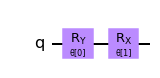

In [3]:
# Parameters are initialized with a simple string identifier
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit_2param = QuantumCircuit(1)

# We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
circuit_2param.ry(theta = parameter_0, qubit = 0)
circuit_2param.rx(theta = parameter_1, qubit = 0)
circuit_2param.draw('mpl')

For convenience, there also exists a ```ParameterVector``` class in Qiskit which allows for the creation of multiple parameters at once. Consider the following example of a [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit, which consists of alternating layers of parameterized $R_Y$ gates and entangling $CX$ gates. 

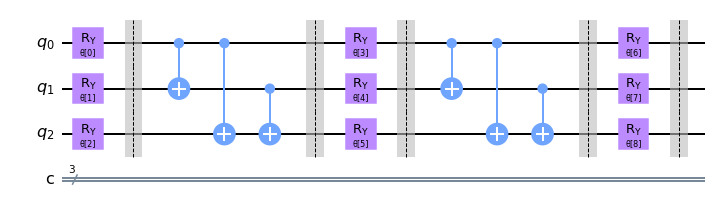

In [4]:
# Set the number of layers and qubits
n=3
num_layers = 2

# ParameterVectors are initialized with a string identifier and an integer specifying the vector length
parameters = ParameterVector('θ', n*(num_layers+1))

ra_circuit = QuantumCircuit(n, n)
for layer in range(num_layers):
    # Appending the parameterized Ry gates using parameters from the vector constructed above
    for i in range(n):
        ra_circuit.ry(parameters[n*layer+i], i)
    ra_circuit.barrier()

    # Appending the entangling CNOT gates
    for i in range(n):
        for j in range(i):
                ra_circuit.cx(j,i)
    ra_circuit.barrier()

# Appending one additional layer of parameterized Ry gates
for i in range(n):
    ra_circuit.ry(parameters[n*num_layers+i], i)
ra_circuit.barrier()

ra_circuit.draw('mpl')

The [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) variational circuit above is commonly used for classification in quantum machine learning and can also be found in the [circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html) of Qiskit. Do not worry too much about this yet though, we will get into these circuits in the projects. 

We can inspect the parameters that are part of a quantum circuit.

In [5]:
print(ra_circuit.parameters)

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8])])


### 2.2 Assigning values to parameters
So we have essentially just replaced the value of an angle with some symbolic variable. Now let's see how to assign that variable with an actaul value.

A parameterized circuit cannot be executed on a quantum backend until the parameters have been assigned fixed values. To do so, we can use the `QuantumCircuit` methods 

```
assign_parameters(parameters, inplace = False)
bind_parameters(values)
```
The two methods are quite similar and we will typically stick with `assign_parameters` but it is worth knowing the difference.
`bind_parameters` assigns numeric values to the parameters of the circuit,  yielding a new circuit. With `assign_parameters`, one can assign numeric values or substitute parameters by other parameter expressions. Additionally, with `assign_parameters` it is possible to substitute parameters in place instead of yielding a new circuit. 

The values or parameter expressions that should be assigned to the circuit parameters can be provided either as a dictionary, where the keys correspond to the circuit parameters and the dictionary values are the values to bind, or as an iterable of values. In the latter case values are assigned to parameters in the same order as parameters were added to the circuit.

Let's go back to our 2 gate parameterized circuit first.

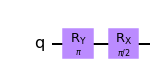

In [6]:
bound_circuit = circuit_2param.assign_parameters(
    parameters = [np.pi, np.pi/2]
)
bound_circuit.draw('mpl')

And for the RealAmplitudes circuit:

{ParameterVectorElement(θ[0]): 0.98016, ParameterVectorElement(θ[1]): 0.62168, ParameterVectorElement(θ[2]): 0.30199, ParameterVectorElement(θ[3]): 0.43425, ParameterVectorElement(θ[4]): 0.15174, ParameterVectorElement(θ[5]): 0.50041, ParameterVectorElement(θ[6]): 0.79371, ParameterVectorElement(θ[7]): 0.36107, ParameterVectorElement(θ[8]): 0.86485}


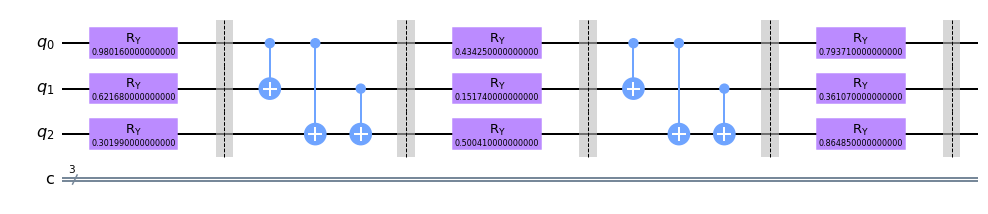

In [7]:
# Create parameter dictionary with random values to bind
param_dict = {parameter: round(np.random.random(), 5) for parameter in parameters}
print(param_dict)

# Assign parameters using the assign_parameters method
bound_circuit = ra_circuit.assign_parameters(
    parameters = param_dict
)
bound_circuit.draw('mpl')

And finally note that we can substitute parameters of the original circuit with others.

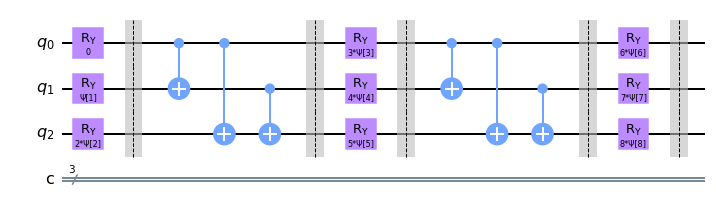

In [8]:
new_parameters = ParameterVector('Ψ',9)
new_circuit = ra_circuit.assign_parameters(parameters = [k*new_parameters[k] for k in range(9)])
new_circuit.draw('mpl')

The bound version of the circuit can now be executed on a quantum device. Attempting to execute a parameterized quantum circuit with non-assigned parameters will throw an error.

### 2.3 Visualizations

Recall that the entire point of these parameterized gates are to help us learn unkown functions/states. As a result, we want to design our circuits to maximize the likelihood that they will be able approximate our function. This typically means enhancing our access to the quantum system's Hilbert space or using some domain knowledge to guess the structure of the solution we are trying to find. That is to say, we either want to make our circuit general enough that $|\psi_0\rangle$ is likely in our space of possible states or we use an educated guess at the structure of $|\psi_0\rangle$ to narrow our serach.
This is an active area of research and a big part of our project so I will only breifly touch on it. 

Consider the single-gate ciruit below and take a look at how much of the bloch sphere it covers

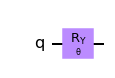

In [9]:
# Parameters are initialized with a simple string identifier
parameter = Parameter('θ')
qc = QuantumCircuit(1)

# We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
qc.ry(parameter, 0)
qc.draw('mpl')

![fbasiscounting](resources/blochvector-1ax.gif)

Now consider the two-gate circuit below.

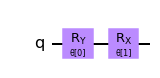

In [10]:
# Parameters are initialized with a simple string identifier
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
qc = QuantumCircuit(1)

# We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
qc.ry(theta = parameter_0, qubit = 0)
qc.rx(theta = parameter_1, qubit = 0)
qc.draw('mpl')

![fbasiscounting](resources/blochvector-2ax.gif)

This may be obvious but it is important to understand when we are researching ansatzes.


## 3 Expectation Values

So now we have the foundations to build quantum circuits that we can tune and use to learn - that is, we can now define $\vert\psi (\theta)\rangle$. Next I want to touch on how to pull some sort of result/measurement from these circuits - that is, let's now define the Hamiltonian $H$ (recall the notation from the variational method in [section 1.3](#1.3-The-Variational-Method)). In quantum mechanics, the Hamiltonian describes the energy of the system and its time evolution as defined by the [Schrodinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation) but here we generalize the meaning to encode whatever quantity we are trying to minimize. 

We evaluate the Hamiltonian by computing what is called the *expectation value*. If you are not familiar with the term, an expectation value is just the average value of a given observable:
$$
\langle\psi(\theta) | H | \psi(\theta)\rangle
$$ 
For those of you with an ML background, the expectaiton value of the Hamiltonian in QML is the function we use to compute the output of the model  and we use it to define our loss function and compute the gradient.

### 3.1 Defining the Hamiltonian

The Hamiltonian is built by combining a bunch of Pauli operators through linear combinations of tensor products. So for a two qubit circuit you could have something like:
$$
H = Z \otimes Z + 2 * I \otimes Y + X \otimes Z
$$
This is arbitrary but Hamiltonians are built based on the problem you are trying to solve. For the [protien folding problem](https://www.nature.com/articles/s41534-021-00368-4), the Hamiltonian of the algorithm is designed based on the structure of the protien and the constraints on how it can fold. For QML, it is common to use a simple Hamiltonian since there isn't much physical meaning in the problem and it is often reasonable to assume that the structure of the Hamlitonian is learned in the variational section of the circuit.

In Qiskit Hamiltonians are easily defined using the `qiskit.opflow` module ([this](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html) in an indepth overview of the modules functionality) where operators can be tensored using the `^` operator:

In [21]:
from qiskit.opflow import I, X, Y, Z, StateFn, CircuitSampler

In [12]:
hamiltonian = Z ^ Z
print(hamiltonian)

ZZ


In [13]:
hamiltonian = (Z ^ X) +  (X ^ Z)
print(hamiltonian)

1.0 * ZX
+ 1.0 * XZ


Try to make the Hamiltonian: $H = Z \otimes Z + 2 * I \otimes Y + X \otimes Z$

In [16]:
hamiltonian = Z ^ Z + 2 * (I ^ Y) + Z ^ Z
print(hamiltonian)

ValueError: Sum over operators with different numbers of qubits, 1 and 2, is not well defined

### 3.2 Computing the expectation value
Again with the ``qiskit.opflow`` module, we can write and evaluate expectation values. The general structure for an expectation value where the state is prepared by a circuit is

    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    result = expectation.eval()
    
The above code uses plain matrix multiplication to evaluate the expected value, which is inefficient for large numbers of qubits. Instead, we can use a simulator (or a real quantum device) to evaluate the circuits by using a ``CircuitSampler`` in conjunction with an expectation converter like ``PauliExpectation``:

    sampler = CircuitSampler(q_instance)  # q_instance is our quantum simulator or device
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    in_pauli_basis = PauliExpectation().convert(expectation)
    result = sampler.convert(in_pauli_basis).eval()
    
Calculate the expected value of the following Hamiltonian ``H`` and state prepared by the circuit ``U`` with plain matrix multiplication.

In [34]:
H = X ^ X

U = QuantumCircuit(2)
U.h(0)
U.cx(0, 1)

# YOUR CODE HERE
backend = State
sampler = CircuitSampler(backend)
expectation = StateFn(H, is_measurement=True) @ StateFn(U)
in_pauli_basis = PauliExpectation().convert(expectation)
result = sampler.convert(in_pauli_basis).eval()

print(result)

QiskitBackendNotFoundError: 'No backend matches the criteria'

### 3.3 Combining it all together
We can then use the expectation and our parameterized circuits to build model that we can use to learn a task. To give you an idea of what this might look like, let's go back to our two-gate parameterized circuit:

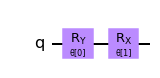

In [31]:
circuit_2param.draw('mpl')

Now we can build our expectation value and a general function that takes some parameters values and uses those to compute the expectation value. We can then use a gradient approximation technique like [finite difference](https://en.wikipedia.org/wiki/Finite_difference):
$$
\nabla f(\theta) \approx \frac{f(\theta+\epsilon) - f\theta-\epsilon)}{2\epsilon}
$$
Since we have a paremeter vector, we compute this by each component:
$$
\frac{\partial f(\vec\theta)}{\partial \theta_i} \approx \frac{f(\vec\theta+\epsilon\hat e_i) - f(\vec\theta-\epsilon\hat e_i)}{2\epsilon}
$$

In [32]:
H = Z
ansatz = circuit_2param

expectation = StateFn(H, is_measurement=True) @ StateFn(ansatz)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))  # dictionary with parameter values
    expectation_bound = expectation.assign_parameters(value_dict)
    result = expectation_bound.eval()  
    return np.real(result)

In [33]:
eps = 0.002
e_i = np.array([0, 1])  # only vary one component of theta at a time

theta = np.random.rand(2)

plus = theta + eps * e_i
minus = theta - eps * e_i

grad = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(grad)

-0.721868284545707


Using this approximation of the gradient, we can then use gradient descent to adjust our parameters and converge to some local minimum which represents our solution. And that's it! We can now (sort of) build a QML model! 

This may have been a particularly breif explanation of how we can make quantum circuits learn but I just wanted to expose you to some of the ideas we will be exploring in our project. So don't worry if you are confused about how to actually design a variational quantum algorithm - that's what we will be exploring in the next few months!